# EOF of CalCS CO2 Fluxes

What if we just perform an EBUS-wide EOF of the Natural CO2 fluxes to see if major patterns arise?

In [656]:
import numpy as np
import xarray as xr
import esmtools as et
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import glob
from eofs.xarray import Eof

# EOF of the region...

What does the EOF of CO2 flux look like?

In [615]:
def eof(x):
    """
    Computes an eof for the whole ensemble, returning a dataset
    with dimension ensemble.
    
    Currently optimized for the CalCS since we need to put all the phases in sync.
    """
    coslat = np.cos(np.deg2rad(x.TLAT.values))
    wgts = np.sqrt(coslat)
    solver = Eof(x, weights=wgts, center=False)
    eof = solver.eofsAsCorrelation(neofs=3)    
    pc = solver.pcs(npcs=3, pcscaling=1)
    variance = solver.varianceFraction(neigs=3)
    eof0 = eof.sel(mode=0).values
    if eof0[30,15] < 0:
        """
        Force system outgassing.
        """
        eof0 = eof0 * -1
        # Awkward syntax due to Python limitations
        # ref: https://stackoverflow.com/questions/40029618/how-to-update-xarray-dataarray-using-sel-indexer
        eof.loc[dict(mode=0)] = eof0
        pc.loc[dict(mode=0)] = pc.sel(mode=0) * -1
    eof1 = eof.sel(mode=1).values
    if eof1[30,12] > 0:
        """
        Force onshore outgassing.
        """
        eof1 = eof1 * -1
        eof.loc[dict(mode=1)] = eof1
        pc.loc[dict(mode=1)] = pc.sel(mode=1) * -1
    eof2 = eof.sel(mode=2).values
    if eof2[20,20] < 0:
        """
        Force equatorward outgassing
        """
        eof2 = eof2 * -1
        eof.loc[dict(mode=2)] = eof2
        pc.loc[dict(mode=2)] = pc.sel(mode=2) * -1
    # Force into dataset.
    ds = eof.to_dataset()
    ds['pc'] = pc
    ds['variance'] = variance   
    return ds

In [616]:
filepath = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_ALT_CO2/CalCS/filtered_output/'
filename = 'calcs-FG_ALT_CO2-residuals-chavez-800km.nc'
ds = xr.open_dataset(filepath + filename)
ds = ds['FG_ALT_CO2']

# Apply to Ensemble

In [617]:
ds = ds.groupby('ensemble').apply(eof)

/glade/u/home/rbrady/.local/lib/python3.6/site-packages/eofs/xarray.py:271: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})
/glade/u/home/rbrady/.local/lib/python3.6/site-packages/eofs/xarray.py:178: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})
/glade/u/home/rbrady/.local/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


# Plot

In [644]:
lon = ds.TLONG
lat = ds.TLAT
data = ds['eofs'].sel(mode=2).mean(dim='ensemble').to_masked_array()
ds['variance'].sel(mode=2).mean()

<xarray.DataArray 'variance' ()>
array(0.0852637687707131)
Coordinates:
    mode     int64 2

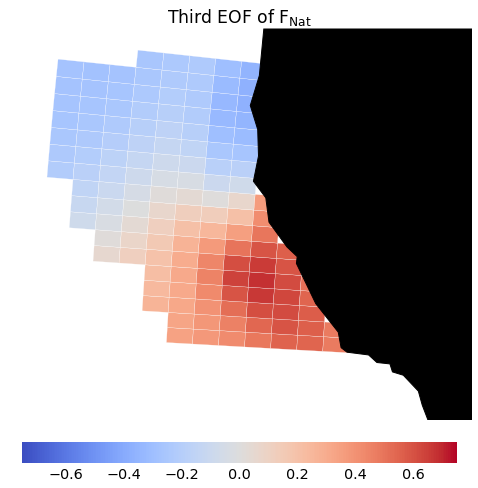

In [646]:
f, ax = et.vis.make_cartopy(projection=ccrs.Mercator(), grid_lines=False,
                            frameon=False)
x0,x1,y0,y1 = et.ebus.visual_bounds('CalCS')
ax.set_extent([x0, x1, y0, y1])

p = plt.pcolor(lon-0.5, lat, data, transform=ccrs.PlateCarree(), edgecolor='w',
               vmin=-0.75, vmax=0.75, cmap="coolwarm")
cb = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05)

ax.set_title('Third EOF of F$_{\mathrm{Nat}}$')